In [2]:
#%run 'word2vec_data.ipynb'
import cPickle as pickle
%pylab inline

import scipy
import numpy as np
import pandas as pd
#import plotly.plotly as py
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from gensim import models


import math
import codecs
import re
import string
from time import time


## Sklearn
from sklearn import svm, datasets
import sklearn

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler, label_binarize, Imputer, OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, RandomTreesEmbedding
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import datasets, feature_selection, cluster, feature_extraction
from sklearn import neighbors, decomposition, metrics
from sklearn import grid_search, decomposition, feature_selection, model_selection
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


from sklearn.pipeline import Pipeline, make_pipeline
from scipy import interp

#############################
### Matplotlib
import matplotlib.pyplot as plt # module for plotting 
from matplotlib import interactive, font_manager
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

#############################
### other stuff
from IPython import display

import os
#import ipyparallel as ipp
import warnings
warnings.filterwarnings('ignore')

# This is here to avoid all the Matplotlib warnings due to current bugs 
# - not a good idea to keep around
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

print ("Required Libraries loaded.")

Populating the interactive namespace from numpy and matplotlib
Required Libraries loaded.


In [3]:
#!pip install --upgrade version_information
#%reload_ext version_information
%load_ext version_information 
%version_information scipy, numpy, sklearn, pandas, scipy, nltk, gensim, matplotlib, os, cpickle

Software,Version
Python,2.7.12 64bit [MSC v.1500 64 bit (AMD64)]
IPython,5.1.0
OS,Windows 7 6.1.7601 SP1
scipy,0.18.1
numpy,1.11.2
sklearn,0.18.1
pandas,0.19.1
scipy,0.18.1
nltk,3.2.1
gensim,0.12.4


In [4]:
inhibitor  = pd.read_csv("C:\EPC_Data\TREC_BROKEN\No_Mh_Tag/betaBlockers_no_mh.csv", sep=",", index_col = "PMID")

In [5]:
folder = "C:\Users\CR107\Dropbox\PhD\Experiments\TREC_2004\data\word2vec"
filepath = os.path.join(folder, "betaBlockers_chi2_features_10minwords_15context")
model = models.Word2Vec.load(filepath)
print (model["clinical"][:10])
print ("\nMatrix of word vectors is size : ", model.syn0.shape)

[ 0.05565824 -0.00830883 -0.15239416  0.0178915   0.00840803 -0.10640141
 -0.10699921 -0.03581474  0.02091357  0.00758347]
('\nMatrix of word vectors is size : ', (3667L, 194L))


In [6]:
#Create feature vectors from the averages of word vectors

def makeFeatureVec(words, model):
    """
    words - list of words (i.e. article) to be used as input for the creation of word vectors
    model - model to use for the creation of the vectors
    
    makeFeatureVec: Function to average all of the word vectors in a given paragraph
    returns: a numpy array of floats that are the average of the constituent word vectors for each word
    """
    num_features = model.syn0.shape[1]
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index2word)
    #
    # Loop over each word in the article and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(articles, model):
    """
    articles - list of articles for which the creation of word vectors needs to be done for each
    model - model to use for the creation of the vectors
    
    getAvgFeatureVecs: Given a set of articles (each one a list of words), calculate 
    the average feature vector for each one and return a 2D numpy array 
    returns: a 2D numpy array that contains the average of the constituent word vectors for each article
    """
    num_features = model.syn0.shape[1]
    articleFeatureVecs = np.zeros((len(articles),num_features),dtype="float32")
    counter = 0.
    
    # Loop through the articles
    for article in articles:
        #
        # Print a status message every 1000th review
        if counter%500. == 0.:
            print ("Article %d of %d" % (counter, len(articles)))
        # 
        # Call the function (defined above) that makes average feature vectors
        articleFeatureVecs[counter] = makeFeatureVec(article, model)
        #
        # Increment the counter
        counter = counter + 1.
    return articleFeatureVecs

In [7]:
# Import articles for string cleaning

def clean_text(text, stem_words = False, remove_stopwords = False):
    ###clean
    texts = re.sub("[^a-zA-Z]",    #pattern to match
              " ",              #replace other with this
              str(text))                 #text to apply to
         
    #print "Text recived: ", texts 
    clean_corpus = texts.lower().split()
    #print "corpus: ", clean_corpus
    if stem_words:
        # Porter stemmer
        porter = nltk.PorterStemmer()
        # Snowball stemmer
        snowball = nltk.SnowballStemmer('english')
        # Lancaster stemmer
        lancaster = nltk.LancasterStemmer()
        # General stemming Lambda function to stem tokens
        clean_corpus = lambda tokens: [porter.stem(w) for w in corpus]
    if remove_stopwords:   # Optionally remove stop words
        stops = set(stopwords.words("english"))
        clean_corpus = [w for w in clean_corpus if not w in stops]
        #print "Clean_corpus: ", clean_corpus
    
    return (clean_corpus)

In [8]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. We remove stopwords.

print ("Creating average feature vecs for articles")
cleaned_articles = []
for article in inhibitor.TIABSMh:
    cleaned_articles.append(clean_text(article, stem_words=False, remove_stopwords=True ))

averageWordVecs = getAvgFeatureVecs(cleaned_articles, model)

Creating average feature vecs for articles
Article 0 of 2043
Article 500 of 2043
Article 1000 of 2043
Article 1500 of 2043
Article 2000 of 2043


In [9]:
RANDOM_STATE = 55
TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=37)

print (len(X_train))
print (len(X_test))

1430
613


In [10]:
yTrFreq = scipy.stats.itemfreq(inhibitor.Label)
print(yTrFreq)

[[   0 1897]
 [   1  146]]


In [11]:
def weight(x):
    x = np.where(x==0, 1, 4)
    return x 

In [22]:
clf = SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
              gamma='auto', kernel='linear', max_iter=-1, probability=False, random_state=55, shrinking=True,
              tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []



for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=seed)

    w = weight(y_train)
    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)



    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train)#, sample_weight = w)
    pred = clf.predict(X_test)

        

    s_vector = clf.n_support_
    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    acc_s = metrics.accuracy_score(y_test, pred)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])
        

    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Fitting for Seed = 35
[[446 129]
 [  8  30]]
Fitting for Seed = 71
[[449 124]
 [  7  33]]
Fitting for Seed = 21
[[448 108]
 [ 16  41]]
Fitting for Seed = 61
[[442 126]
 [ 12  33]]
Fitting for Seed = 55
[[431 142]
 [  6  34]]
SVM Cross validation results: 
Mean Precision: 0.21 +/- 0.03 
  Mean  Recall: 0.78 +/- 0.05
      Mean  F1: 0.34 +/- 0.03
Mean  Accuracy: 0.78 +/- 0.01
(' True Negative: ', [446, 449, 448, 442, 431])
('False Negative: ', [8, 7, 16, 12, 6])
(' True Positive: ', [30, 33, 41, 33, 34])
('False Positive: ', [129, 124, 108, 126, 142])
('Negative support Vectors: ', array([ 763.,  782.,  719.,  749.,  786.]))
('Positive support Vectors: ', array([ 66.,  65.,  51.,  60.,  67.]))
Mean positive support vectors: 61.80 +/- 5.91
Mean Negative support vectors: 759.80 +/- 24.38
Train positive: 102.00
Train negattive: 1328.00
Test positive: 44.00
Test negative: 569.00


In [19]:
##  based on this SciKitLearn example:
# http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

# options
print_report = True
print_cm = True
print_top10 = True
n_features = 2 ** 16
filtered = True

########
# Load some categories from the training set

#RANDOM_STATE = 55

sw_train = weight(y_train)
#sw_test = weight(y_test)

categories = ['Irrelevant', 'Relevant']
print('Training and test datasets created')

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


########
# Benchmark the classifiers, one at a time
def benchmark(clf, name):
    """
    clf - the classifier
    name - its name
    
    benchmark: to create the benchmark metrics for the classification
    returns: the inputs to the results list
    """
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    try:
        clf.fit(X_train, y_train, sample_weight = sw_train)#with weight
    except:
        clf.fit(X_train, y_train)#no weight
        
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    
    acc_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc_score)
    
    prec_score = metrics.precision_score(y_test, pred)
    print("precision:  %0.3f" % prec_score)
    
    recall = metrics.recall_score(y_test, pred)
    print("recall:     %0.3f" % recall)
    
    # get the decision boundary or the probas.
    if hasattr(clf, "decision_function"):
        y_score = np.array(clf.decision_function(X_test))
    else:
        y_score = clf.predict_proba(X_test)[:,1]
        
    if hasattr(clf, "n_support_"):
        print ("Complexity: ", clf.n_support_)

    auc_score = metrics.roc_auc_score(y_test, y_score)
    print("*** AUC for ROC = %0.3f\n" % auc_score)
    
    #if hasattr(clf, 'coef_'):
    #    print("dimensionality: %d" % clf.coef_.shape[1])
    #    print("density: %f" % density(clf.coef_))
    #    print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=categories))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return name, acc_score, auc_score, prec_score, recall, train_time, test_time

def create_results():
    """
    create_results: to run the classification and create the of results 
    from the battery of classifiers
    returns: an multiD list of results
    """
    results = []
    for clf, name in (
            (SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1.0"),
            (SVC(kernel="linear", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=10.0"),
            (SVC(kernel="linear", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=100"),
            (SVC(kernel="linear", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1000"),
            (SVC(kernel="linear", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=10000"),
            (SVC(kernel="rbf", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1"),
            (SVC(kernel="rbf", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10"),
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100"),
            (SVC(kernel="rbf", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1000"),
            (SVC(kernel="rbf", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=10000"),
            ):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, name))

    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                                dual=False, tol=1e-3, random_state=RANDOM_STATE, class_weight = 'balanced'), "Linear SVC %s penalty" %penalty))


        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD classifier %s penalty" %penalty))
        results.append(benchmark(SGDClassifier(loss="hinge", alpha=.0001, n_iter=50,
                                       penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD hinge loss %s penalty" %penalty))
        results.append(benchmark(SGDClassifier(loss="log", alpha=.0001, n_iter=50,
                                   penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD log loss %s penalty" %penalty))
    return results

def comparison_plots(results):
    """
    results - array containing the results from the classification to plot
    
    yields: prints out the results from each classifier and then finishes with plots of the 
    accuracy scores and ROC AUC scores for all the classifiers
    """
    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet", random_state=RANDOM_STATE, class_weight = 'balanced'),"Elastic-Net penalty"))

    # Train sparse Naive Bayes classifiers
    #print('=' * 80)
    #print("Naive Bayes")
    #results.append(benchmark(MultinomialNB(alpha=.01),"Multinomial Naive Bayes"))
    #results.append(benchmark(BernoulliNB(alpha=.01),"Bernouilli Naive Bayes"))

    #print('=' * 80)
    #print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    #results.append(benchmark(Pipeline([
    #  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3, random_state=RANDOM_STATE, class_weight = 'balanced')),
    #  ('classification', LinearSVC())
    #            ]),"LinearSVC - L1 feature selection"))

    ######
    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(7)]

    clf_names, acc_score, auc_score, prec_score, recall, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    ######
    #  Make a plot for the accuracy scores 
    plt.figure(figsize=(12, 8))
    plt.title("Accuracy Score")
    plt.barh(indices, acc_score, .2, label="accuracy score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()
    
    ######
    #  Make a plot for the ROC curve AUC scores 
    plt.figure(figsize=(12, 8))
    plt.title("ROC curve AUC Score")
    plt.barh(indices, auc_score, .2, label="AUC score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()
    

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.show()

Training and test datasets created


Linear SVC C=1.0
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.458s
test time:  0.158s
accuracy:   0.067
precision:  0.065
recall:     1.000
('Complexity: ', array([1324,   34]))
*** AUC for ROC = 0.816

classification report:
             precision    recall  f1-score   support

 Irrelevant       1.00      0.00      0.00       573
   Relevant       0.07      1.00      0.12        40

avg / total       0.94      0.07      0.01       613

confusion matrix:
[[  1 572]
 [  0  40]]
()
Linear SVC C=10.0
________________________________________________________________________________
Training: 
SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='

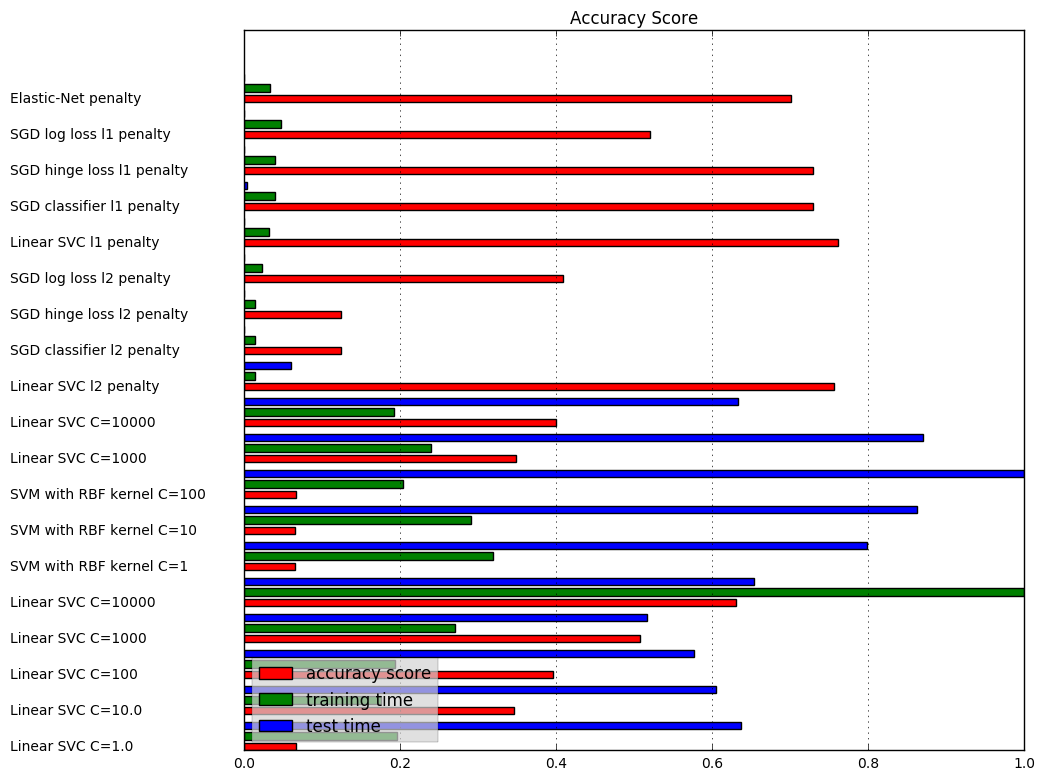

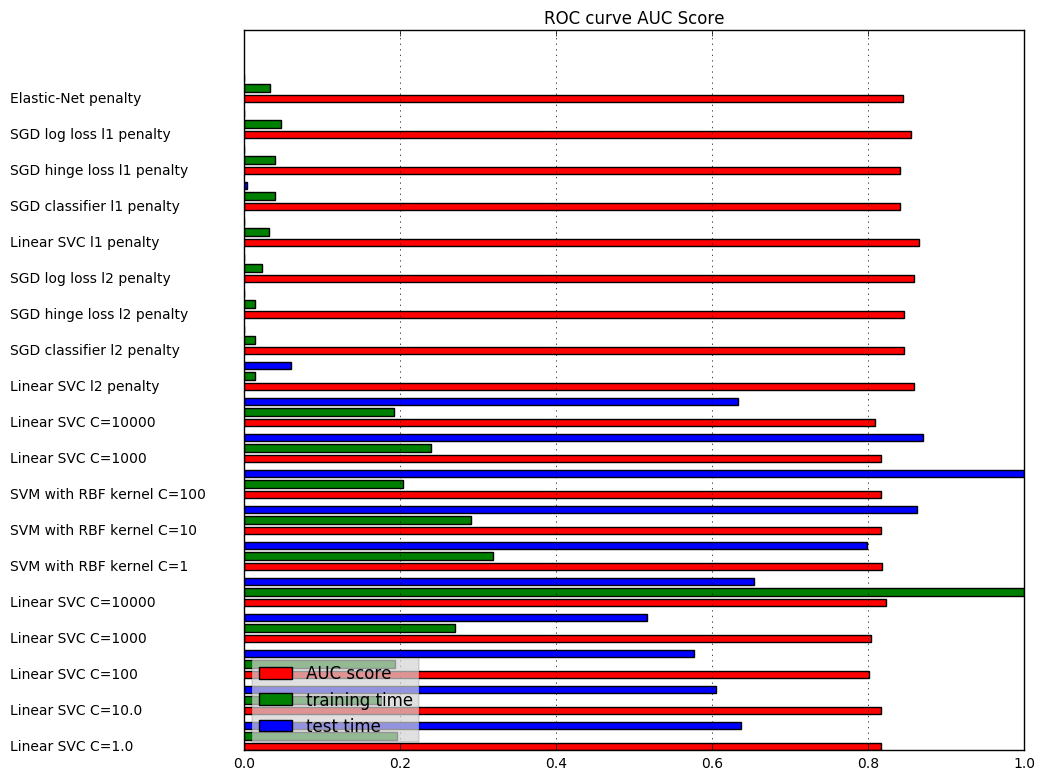

In [20]:
# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())

In [25]:
# Function to compute ROC curve and ROC area for each class
# based on the example in SciKitLearn
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def plot_ROC_curve(y_test, y_score):
    """
    y_test - truth series, single array
    y_score - prediction series, single array
    
    yields: plot of curve
    The function will plot the ROC curve and an embedded legend with the AUC score.
    """
    sw_test = weight(y_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_score, sample_weight=sw_test)
    roc_auc = auc(fpr, tpr)
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0:0.3f})' .format(roc_auc), linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

# Compute Precision-Recall and plot curve
# As above, based on the SciKit Learn example

def plot_PR_curve(y_test, y_score):
    """
    y_test - truth series, single array
    y_score - prediction series, single array
    
    yields: plot of curve
    The function will plot the precision recall curve and an embedded legend with the AUC score.
    """
    sw_test = weight(y_test)
    
    precision = dict()
    recall = dict()
    precision, recall, _ = precision_recall_curve(y_test, y_score, pos_label=1, sample_weight=sw_test)
    
    # Plot Precision-Recall curve for each class
    plt.clf()
    plt.plot(recall, precision, label='Precision-recall curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right")
    plt.show()

# Convenience function to adjust plot parameters for a clear layout.
target_names = ["Excluded", "Included"]

def show_confusion_matrix(cm):
    """
    cm - confusion matrix parameters as output from confusion_matrix() function
    
    yields: a plot of the confusion matrix with imshow
    Convenience function to adjust confusion matrix plot parameters for a clear layout.
    """
    sw_test = weight(y_test)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_stats(clf, x_train, x_test, y_train, y_test):
    """
    clf - classifier
    x_train - matrix of training features
    x_test - matrix of training features
    y_train - array of training labels
    y_test - array of validation truths
    yields: print outs of the full suite of metrics for the classification for both training and validation sets
    """
    print(clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)

    print("Number of mislabeled points out of a total %d training points : %d"
          % (x_train.shape[0],(y_train != y_pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the training set: ", clf.score(x_train, y_train)), '\n')
    scores1 = cross_val_score(clf, x_train, y_train, cv=2, scoring = 'accuracy' , n_jobs = 1)
    scores2 = cross_val_score(clf, x_train, y_train, cv=2, scoring = 'f1' , n_jobs = 1)
    report = precision_recall_fscore_support(y_train, y_pred, average='macro')
    acc_score = accuracy_score(y_train, y_pred)#, sample_weight=sw_test)
    cm = confusion_matrix(y_pred, y_train)

    print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f\n" % 
          (report[0], report[1], report[2], acc_score))
    print("\n10-fold CV mean accuracy = %0.3f, mean F1 = %0.3f\n" % 
          (scores1.mean(), scores2.mean()))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the training set: \n",pd.DataFrame(cm) )
    show_confusion_matrix(cm)

    pred = clf.predict(x_test)

    print("Number of mislabeled points out of a total %d testing points : %d"
          % (x_test.shape[0],(y_test != pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the testing set: ", clf.score(x_test, y_test)), '\n')
    report = precision_recall_fscore_support(y_test, pred, average='macro')
    acc_score = accuracy_score(y_test, pred)
    cm = confusion_matrix(pred, y_test)

    print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f\n" % 
          (report[0], report[1], report[2], acc_score))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the testing set: \n",pd.DataFrame(cm))
    show_confusion_matrix(cm)

In [26]:
#RANDOM_STATE = 55

def run_class(X, y, TEST_SIZE):
    """
    X - input matrix of features for the classification
    y - array of truths for the classification 
    TEST_SIZE - number or proportion to use for the test set - int is number, float is precentage
    
    yields: this version runs a battery of classifiers. For each of them, it  
    prints out the performance metrics for the classification and plots the ROC and PR curves
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)    
    
    sw_test = weight(y_test)
    
    for clf, name in (
            -
        
        print("\n", name, "\ntest size is %d %%  " % (TEST_SIZE*100))

        clf.fit(X_train, y_train)
        print (clf.score(X_test, y_test))
        
        mean_acc_score = clf.score(X_test, y_test)
        pred = clf.predict(X_test)

        report = precision_recall_fscore_support(y_test, pred, average='binary', sample_weight=sw_test)
        acc_score = accuracy_score(y_test, pred)
        cm = confusion_matrix(pred, y_test)

        # get the decision boundary or the probas.
        if hasattr(clf, "decision_function"):
            y_score = np.array(clf.decision_function(X_test))
        else:
            y_score = clf.predict_proba(X_test)[:,1]

        auc_score = metrics.roc_auc_score(y_test, y_score, sample_weight=sw_test)

        #print("mean_accuracy = %0.3f" % mean_acc_score)
        print("precision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f" % 
              (report[0], report[1], report[2], acc_score))
        print("The confusion matrix on the testing set:          \n", pd.DataFrame(cm))
        print("*********** AUC for ROC = %0.3f" % auc_score)
                
        plot_ROC_curve(y_test, y_score)
        plot_PR_curve(y_test, y_score)
        #print (y_score[:,:30])

In [27]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'class_weight':['balanced', None],
                     'random_state':[55, 21, 71, 35, 61],
                     'C': [1, 10, 100, 1000]},
                    
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'class_weight':['balanced', None],
                     'random_state':[55, 21, 71, 35, 61],}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=2, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'kernel': 'linear', 'C': 1000, 'random_state': 55, 'class_weight': 'balanced'}
()
Grid scores on development set:
()
0.463 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 55, 'gamma': 0.001, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 21, 'gamma': 0.001, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 71, 'gamma': 0.001, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 35, 'gamma': 0.001, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 61, 'gamma': 0.001, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 55, 'gamma': 0.0001, 'class_weight': 'balanced'}
0.463 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 21, 'gamma': 0.0001, 'class_weight': 'balanced'}
0.463 (+/-0

In [30]:
# Set the parameters by cross-validation
#linearsvc


tuned_parameters = [{'C': [1.0, 10, 100, 1000],
                     #'penalty': ['l2', 'l1'],
                     'class_weight':['balanced', None],
                     'random_state':[55, 21, 71, 35, 61],
                     #'loss': ['squared_hinge', 'hinge'],
                     #'dual': [True, False],
                     'multi_class': ['crammer_singer', 'ovr']
                     }]

                    
scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LinearSVC(), tuned_parameters, cv=2, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall
()


KeyboardInterrupt: 

In [ ]:
# Set the parameters by cross-validation
#PERCEPTRON
tuned_parameters = [{'n_iter': [2, 5, 10,50],
                     'penalty': [None, 'l2', 'l1', 'elasticnet'],
                     'alpha': [0.001, 0.0001, 0.00001],
                     'random_state':[55, 21, 71, 35, 61],
                     'class_weight':['balanced', None]
                    }]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(Perceptron(), tuned_parameters, cv=2, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

In [ ]:
##run 2

In [ ]:
RANDOM_STATE = 61

# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)

In [ ]:
#run 3
RANDOM_STATE = 21


# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)

In [ ]:
#run 4
RANDOM_STATE =71
TEST_SIZE = 0.4



# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)

In [ ]:
#run 5
RANDOM_STATE = 35

# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)